<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/Isotipo-Negro.gif" title="Title text" width="20%" height="20%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-393 Máquinas de Aprendizaje II-2019 </h1>

<H3 align='center'> Tarea 2 - Fronteras no Lineales </H3>
<H3 align='center'> Sección 2 - Problema de Múltiples Anotaciones </H3>
<hr style="height:2px;border:none"/>
<center>
    <h4> Sebastián Godínez San Martín, 201673520-8</h4>
    <h4> Daniel Toro, 201673595-K </h4> 
</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

El aprendizaje supervisado visto en clases da cuenta que existe una única posible etiqueta $z$ (*ground truth*) asociada a un dato $x$ para poder aprender de los datos. Sin embargo, la definición del *ground truth* en algunos casos puede resultar bastante difícil de definir o bastante costoso, por ejemplo en problemas médicos donde se deben realizar invasivos exámenes para conocer la "verdad absoluta". Como alternativa se pueden recolectar múltiples anotaciones desde personas inexpertas en el área para poder estimar el *ground truth*. 

<img src="http://www.irishenvironment.com/wp-content/uploads/2013/11/crowdsourcing.jpg" title="Title text" width="40%" />

En esta actividad se trabajará en el caso en que contamos con múltiples anotaciones por cada dato de entrada $x_i$ dadas por personas inexpertas a través de Amazon Mechanical Turk (__[AMT](https://www.mturk.com/)__), es decir, $y^{(1)}, y^{(2)} \ldots y^{(T_i)}$. El problema de predicción trabajado será el mismo de la actividad anterior, el análisis de sentimiento de un extracto de texto en Rotten Tomatoes. Los datos trabajados [[8]](#refs) pueden ser descargados de la página del autor.
```
wget http://fprodrigues.com//mturk-datasets.tar.gz
```

De esta manera trabajaremos con el archivo *mturk_answers.csv* en la carpeta *sentiment polarity* que se puede cargar con pandas. En este archivo se tendrán múltiples filas/registros por cada dato de entrenamiento, cada uno representando la etiqueta que entregó una persona (*worker*) a ese dato, los detalles de columnas son:
* *WorkerId*: identificador de la persona que etiquetó/anotó el dato
* *Input.id*: identificador del dato a etiquetar/anotar
* *Input.original_sentence*: texto original del dato
* *Input.stemmed_sent*: texto pre-procesado
* *Input.true_sent*: sentimiento real (*ground truth*) del dato
* *Answer.sent*:   etiqueta/anotación que entregó la persona
```python
df = pd.read_csv("./mturk-datasets/sentiment_polarity/mturk_answers.csv") 
```

> El objetivo de la actividad será el de obtener un modelo predictor del *ground truth* sin entrenar directamente con esto, sino que utilizar las múltiples anotaciones de las personas

### Importante
* Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento *ground truth* (sin repeticiones)
* Los valores de *ground truth* están **solo para evaluar**, no puede utilizarlos para entrenar o tomar decisiones en su modelo.
* La métrica de evaluación será el *accuracy score*
```python
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)
```

#### Sugerencias
Para representar los textos, a diferencia de lo visto en la sección 1, se puede utilizar lo que son la representación vectorial de palabras (*word vectors*), a través de modelos especializados entrenados para aprender una representación en que palabras similares estén cercanas en el espacio vectorial. Puede utilizar los vectores livianos de __[GLOVE](https://nlp.stanford.edu/projects/glove/)__ en su versión entradas en textos de Wikipedia con 6 billones de palabras/tokens.
```python
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B/glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
...
embeddings_index.get(word)
```
> Para descargar GLOVE
```
wget http://nlp.stanford.edu/data/glove.6B.zip
```
### Consideraciones
Se asume que _mturk-datasets.tar.gz_ y _glove.6B.zip_ estan descomprimidos en la misma carpeta donde se encuentra este Notebook, generando automaticamente las carpetas _mturk-datasets_ y _glove.6B_ respectivamente.

In [2]:
df = pd.read_csv("./mturk-datasets/sentiment_polarity/mturk_answers.csv")
df

,WorkerId,Input.id,Input.original_sentence,Input.stemmed_sent,Input.true_sent,Answer.sent
0,A2HD5XMM48KKJW,4518,"the cast is phenomenal , especially the women .",cast phenomen especi women,pos,pos
1,A2HD5XMM48KKJW,10415,"the metaphors are provocative , but too often ...",metaphor provoc often viewer left puzzl mechan...,neg,neg
2,A2HD5XMM48KKJW,7098,while there's something intrinsically funny ab...,there someth intrins funni sir anthoni hopkin ...,neg,pos
3,A2HD5XMM48KKJW,4396,a harrowing account of a psychological breakdo...,harrow account psycholog breakdown,pos,neg
4,A2HD5XMM48KKJW,2812,". . . a visually seductive , unrepentantly tr...",visual seduct unrepentantli trashi rice instal...,pos,pos
...,...,...,...,...,...,...
27741,A4F3BK6J0PCVH,7144,the movie fails to live up to the sum of its p...,movi fail live sum part,neg,neg
27742,A4F3BK6J0PCVH,8293,the balkans provide the obstacle course for th...,balkan provid obstacl cours love good woman,neg,neg
27743,A4F3BK6J0PCVH,2929,this is a smart movie that knows its classical...,smart movi know classic music know freud know ...,pos,pos
27744,A4F3BK6J0PCVH,6902,"there's something with potential here , but th...",there someth potenti movi decid lavinia conser...,neg,neg


En primer lugar se carga el dataset a trabajar con el fin de poder familiarizarnos con la estructura. Se puede observar que tiene un total de 27.746 entradas, donde las columnas importantes son _"Input.stemmed_sent"_ , _"Input.true_sent"_ y _"Answer.sent"_. Dado que la columna _"Input.stemmed_sent"_ es un pre-procesamiento de la columna _"Input.original_sentence"_ no se realizara otro algoritmo para normalizar.

In [3]:
# Deberá crear un conjunto aleatorio de pruebas que solo contenga los textos y el sentimiento ground truth (sin repeticiones)

# se transforman a numero
# 0 = neg ; 1 = pos
def convert(string):
    if "pos" == string:
        return 1
    else:
        return 0

# primero guardamos las distintas respuestas en un diccionario
dict_words = dict()

for index, row in df.iterrows():
    if row["Input.id"] not in dict_words.keys():
        dict_words[row["Input.id"]] = (list(), row["Input.true_sent"], row["Input.stemmed_sent"])
    dict_words[row["Input.id"]][0].append(row["Answer.sent"])
    
# luego, diremos que la respuesta de la gente es la mas votada
labels_person = list()
labels_true = list()
text = list()
for _, (lista, real, sentence) in dict_words.items():
    mas_votada = max(set(lista), key = lista.count) # se elige la mas votada
    # agregamos valores a los conjuntos
    text.append(sentence)
    labels_person.append(convert(mas_votada))
    labels_true.append(convert(real))

Primero se agrupan las respuestas asociada a una frase, identificandolas con el id de la frase. Con esto se elige por mayoria simple la opcion que la gente cree y esto lo utilizamos como conjunto _"y"_ . Dado que las columnas con los resultados son palabras, estas se pasan a numeros para poder trabajarlas, obteniendo que _"neg"_ = 0 y _"pos"_ = 1.

In [4]:
# separamos en conjunto de pruebas y conjunto de validacion
from sklearn.model_selection import train_test_split
text_train, text_val, labels_train, labels_val  = train_test_split(text,
                                                                   labels_person, test_size= int(len(text)*0.3),
                                                                   random_state=0)

print(f"Tamaño conjunto entrenamiento: {len(text_train)} \nTamaño conjunto validacion: {len(text_val)}")

Tamaño conjunto entrenamiento: 3500 
Tamaño conjunto validacion: 1499


Se decide utilizar una proporción conservadora de 70% de los datos para entramiento y 30% de los datos para validar los resultados, es decir, finalmente tenemos 3500 datos de entrenamiento y 1499 datos de validación.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=False) #TF representation
vectorizer.fit(text_train)
vectorizer.transform(text_train)

#transform val and test
# se transforma a partir del fit hecho por la data de training
features_train_count = vectorizer.transform(text_train)
features_val_count = vectorizer.transform(text_val)

print(f"Tamaño con CountVector: {features_train_count.shape}" )

Tamaño con CountVector: (3500, 7562)


Se decide utilizar 3 metodos para vectorizar el conjunto de pruebas, donde el primero sera contar cuantas veces aparece una palabra.

In [6]:
# vectorizamos usando TfidVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_model = TfidfVectorizer(binary=False, 
                              ngram_range=(1, 1), 
                              max_df=1.0, 
                              min_df=1, 
                              max_features=None, 
                              norm='l2', 
                              use_idf=True, 
                              sublinear_tf=False)

tfidf_model.fit(text_train)
features_train_tfid = tfidf_model.transform(text_train)
features_val_tfid = tfidf_model.transform(text_val)

print(f"Tamaño con TfidVectorizer: {features_train_tfid.shape}" )

Tamaño con TfidVectorizer: (3500, 7562)


El segundo metodo a utilizar es TF-IDF, obteniendo una matriz con el mismo tamaño que la construida por CountVector.

In [7]:
# vectorizamos usando GLOVE
EMBEDDING_DIM = 300
GLOVE_FILE = "./glove.6B/glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
#embeddings_index.get(word)

Teniendo los conjuntos ya vectorizados procedemos a utilizar distintos modelos como SVM:

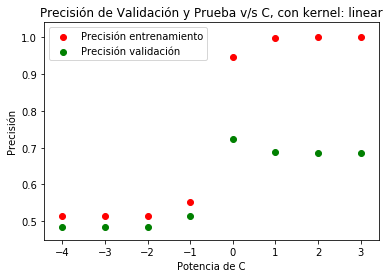

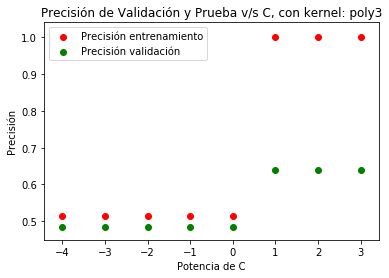

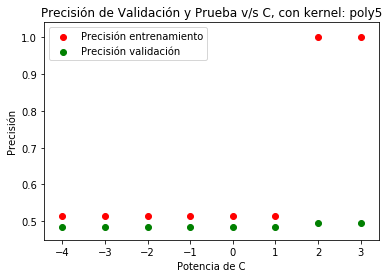

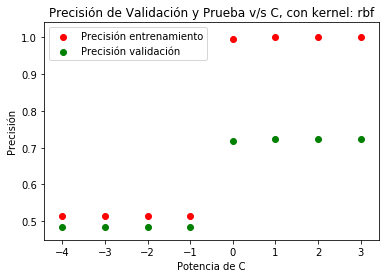

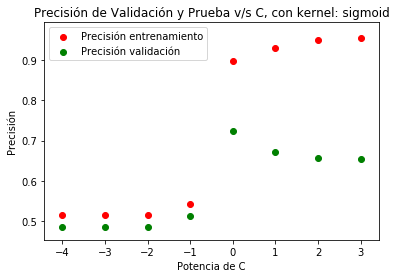

In [8]:
from sklearn.svm import SVC as SVM #SVC is for classification
def do_SVM(x,y,xv,yv, param, kernel='linear', d = 3, probability=False):
    #print("Param C= ",C, 'Kernel= ', kernel)
    model= SVM()
    if kernel == 'poly':
        model.set_params(C=param,kernel=kernel, degree = d, gamma=0.5, probability=probability)
    else:
        model.set_params(C=param,kernel=kernel, probability=probability) #try rbf and linear at least
    model.fit(x,y)
    train_acc = model.score(x,y)
    test_acc = model.score(xv,yv)
    return model, train_acc, test_acc

kernels = ['linear', 'poly3', 'poly5', 'rbf', 'sigmoid']
Cs = [10**int(i) for i in np.arange(-4,4)]

for kernel in kernels:
    trains_acc = list()
    tests_acc = list()
    for c in Cs:
        if 'poly' in kernel:
            _, train_acc, test_acc = do_SVM(features_train_tfid,
                                           labels_train,
                                           features_val_tfid,
                                           labels_val,
                                           param= c,
                                           kernel='poly',
                                           d=int(kernel[-1])) # grado de ser polinomio
        else:
            _, train_acc, test_acc = do_SVM(features_train_tfid,
                                           labels_train,
                                           features_val_tfid,
                                           labels_val,
                                           param= c,
                                           kernel=kernel)
        trains_acc.append(train_acc)
        tests_acc.append(test_acc)

    fig, ax = plt.subplots()
    ax.scatter(np.arange(-4,4), trains_acc, color='red', label="Precisión entrenamiento")
    ax.scatter(np.arange(-4,4), tests_acc, color='green', label="Precisión validación")
    ax.legend(loc='best')
    ax.set_xlabel("Potencia de C")
    ax.set_ylabel("Precisión")
    ax.set_title(f"Precisión de Validación y Prueba v/s C, con kernel: {kernel}")

plt.show()

Comparando los resultados obtenidos, se llega a la conclusion que se utilizara SVM con __kernel rbf__ y __C = 1__. Para comprobar con otros metodos se decidio utilizar una Red Neuronal (ANN) con caracteristicas similares al presente en la Seccion 1.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Text(0.5, 1.0, 'ANN\nPrecisión de Validación y Prueba v/s n° Neuronas')

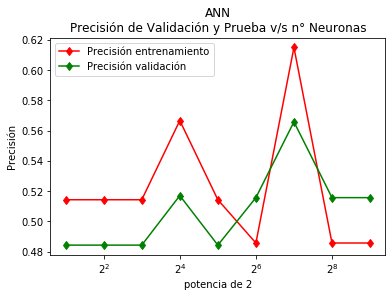

In [10]:
# instalar tensorFlow
# instalar launchpadlib
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
def do_ANN(x,y, xv,yv, param):
    #print("Neuron hidden = ",param)
    model = Sequential()
    model.add(Dense(units=param, input_dim=x.shape[1], activation="sigmoid"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(optimizer=SGD(lr=0.1), loss="binary_crossentropy", metrics=["accuracy"])
    model.fit(x, y, epochs=25, batch_size=128, verbose=0)
    train_acc = model.evaluate(x,y, verbose=0)[1] #in position 0 is the loss
    test_acc = model.evaluate(xv,yv, verbose=0)[1]
    return model, train_acc, test_acc

N_hs = [2**i for i in range(1,10)]

trains_acc = list()
tests_acc = list()
for N_h in N_hs:
    _, train_acc, test_acc = do_ANN(features_train_tfid,labels_train,features_val_tfid,labels_val, param= N_h)
    trains_acc.append(train_acc)
    tests_acc.append(test_acc)
    
plt.plot(N_hs, trains_acc, 'rd-', label="Precisión entrenamiento")
plt.plot(N_hs, tests_acc, 'gd-', label="Precisión validación")
plt.legend(loc='best')
plt.xlabel("potencia de 2")
plt.ylabel("Precisión")
plt.xscale('log',basex=2)
plt.title("ANN\nPrecisión de Validación y Prueba v/s n° Neuronas")

El resultado obtenido por la ANN es bastante malo, debido a que es comparable con el lanzamiento de una moneda. Por lo que se utilizara SVM para entrenar todos los datos:

In [11]:
# se vectorizan todos los datos
# vectorizamos usando TfidVectorizer
tfidf_model = TfidfVectorizer(binary=False, 
                              ngram_range=(1, 1), 
                              max_df=1.0, 
                              min_df=1, 
                              max_features=None, 
                              norm='l2', 
                              use_idf=True, 
                              sublinear_tf=False)

tfidf_model.fit(text)
features_total_tfid = tfidf_model.transform(text)

print(f"Tamaño con TfidVectorizer: {features_total_tfid.shape}" )

Tamaño con TfidVectorizer: (4999, 8886)


Se entrenara con todo el conjunto, para esto es necesario vectorizar nuevamente todo.

In [12]:
from sklearn.metrics import accuracy_score

model = SVM()
model.set_params(C=10**0, kernel="rbf")
model.fit(features_total_tfid, labels_person)


print(f"Precision entrenamiento con valor real: {accuracy_score(labels_true, labels_person)}")

Precision entrenamiento con valor real: 0.8895779155831166


terrible bueno salu2.

<a id="refs"></a>
## Referencias
[1] Keras: Deep Learning library for Theano and TensorFlow. https://keras.io/  
[2] https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews  
[3] https://en.wikipedia.org/wiki/Stopwords  
[4] https://en.wikipedia.org/wiki/Lemmatisation  
[5] Landauer, T. K., Foltz, P. W., & Laham, D. (1998). *An introduction to latent semantic analysis*. Discourse processes, 25(2-3), 259-284.  
[6] https://github.com/cjhutto/vaderSentiment  
[7] https://en.wikipedia.org/wiki/Stemming  
[8] Rodrigues, F., Pereira, F., & Ribeiro, B. (2013). *Learning from multiple annotators: distinguishing good from random labelers*. Pattern Recognition Letters, 34(12), 1428-1436.